# <p><center style="font-family:newtimeroman;font-size:180%;">Alzheimer's 4-class Classification </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Data Preparation](#2)
* [InceptionV3 Model](#3)
* [InceptionV3 Model(base)](#4)
* [InceptionV3 + Additional Capacity](#5)
* [Base Model (InceptionV3) + Optimized Parameters + Data Augmentation](#6)
* [Xception](#7)
* [VGG19](#8)
* [View Images and Labels For VGG19](#9)

<a id="1"></a>
# <p>Import Libraries </p>
<a href="#home"></a>

In [1]:
# Import Libraries
import numpy as np 
import pandas as pd 
import time
import itertools

# file system libraries
import os
import os.path
from   os import path
import shutil

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# splits train folders into train/validation with stratification
import splitfolders  

# Images, Plotting
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# tensorflow - CNNs
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121,InceptionV3, Xception, ResNet101
from tensorflow.keras.applications.vgg19 import VGG19 
from kerastuner.tuners import Hyperband

F:\anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


C:\Users\user\AppData\Local\Temp\ipykernel_21280\3199660385.py:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


<a id="2"></a>
# <p>Data Preparation</p>
<a href="#home"></a>

In [2]:
# Constants
FOLDERS     = ['train','val','test']
DIR_INPUT   = './Alzheimer_s Dataset'
DIR_WORK    = './'
DIR_MODELS  = os.path.join(DIR_WORK,'models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_VAL     = os.path.join(DIR_WORK,'val')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']


# Set seeds for reproducibility 
SEED        = 1985
tf.random.set_seed(SEED)
np.random.seed(SEED)

### 1. Determine the Number of Images for each class

In [3]:
def images_by_class(path,folders):
    """
    Loop through the path/folders count the number and proportions of each class
    """
    
    # accumulators
    normal,verymild,mild,moderate =0,0,0,0
    
    # print header
    msg = '{:8} {:8} {:11} {:7} {:9} {:9} {:11} {:8} {:8}'.format('folder','normal','verymild','mild','moderate',
                                                        'normal %','verymild %','mild %','moderate %')
    print(msg)  
    print("-"*len(msg))
    
    for folder in FOLDERS:
        for dirname,_, filenames in os.walk(os.path.join(path,folder)):
            for file in filenames:
                if "NonDemented" in dirname:
                    normal+=1
                if "VeryMildDemented" in dirname:
                    verymild+=1
                if 'MildDemented' in dirname:
                    mild+=1
                if 'ModerateDemented' in dirname:
                    moderate+=1
                    
        # calculate total and percentages            
        total = normal+verymild+mild+moderate
        if total >0:
            n  = round(normal/total,2)*100
            vm = round(verymild/total,2)*100
            m  = round(mild/total,2)*100
            mo =round(moderate/total,2)*100
        else:
            n,vm,m,mo = 0,0,0,0
        
        print("{:6} {:8} {:10} {:7} {:11} {:8} {:10} {:8} {:12}".format(folder,normal,verymild,mild,moderate,n,vm,m,mo))
        normal,verymild,mild,moderate =0,0,0,0

# Images by class in the input directory
images_by_class(DIR_INPUT,FOLDERS) 

folder   normal   verymild    mild    moderate  normal %  verymild %  mild %   moderate %
-----------------------------------------------------------------------------------------
train      2560       1792    2509          52     37.0       26.0     36.0          1.0
val           0          0       0           0        0          0        0            0
test        640        448     627          12     37.0       26.0     36.0          1.0


### 2. Resample the train dataset into train/validation

In [4]:
# create a new directory if it doesn't exist
def create_dir(dir_path,folder,verbose=True):
    """
    Create the dir_path/folder if it doesn't already exist
    """
    msg = ""
    folder_path = os.path.join(dir_path,folder)
    
    if not path.exists(folder_path):
        try:
            os.mkdir(folder_path)
            msg = folder_path + ' created'
        except OSError as err:
            print('Error creating folder:{} with error:{}'.format(folder_path,err))
    if verbose:
        print(msg)
        
    return folder_path

# create model directory
create_dir(DIR_WORK,'models',True)

'./models'

In [5]:
def resample_train_val_images(input_dir,working_dir,seed=SEED,split = (0.80,0.20)):
    """
    Resample the train images into train/val by the ratios given in split
    """
    # get paths
    dir_test   = os.path.join(input_dir,'test')
    dir_train  = os.path.join(input_dir,'train')
    

    # remove existing files/folders
    for folder in FOLDERS:
        if path.exists(os.path.join(working_dir,folder)):
            shutil.rmtree(os.path.join(working_dir,folder))

            
    # copy the test directory to working
    shutil.copytree(dir_test, os.path.join(working_dir,'test'))
        

    # resample
    splitfolders.ratio(dir_train, working_dir, seed=seed, ratio=split) 
        
    # print image summary by folder
    print("\n Images By Class After Resampling")
    print("-"*67)
    images_by_class(working_dir,FOLDERS)
    
    
resample_train_val_images(DIR_INPUT,DIR_WORK)

Copying files: 5121 files [00:10, 493.03 files/s]


 Images By Class After Resampling
-------------------------------------------------------------------
folder   normal   verymild    mild    moderate  normal %  verymild %  mild %   moderate %
-----------------------------------------------------------------------------------------
train      2048       1433    2006          41     37.0       26.0     36.0          1.0
val         512        359     503          11     37.0       26.0     36.0          1.0
test        640        448     627          12     37.0       26.0     36.0          1.0


### 3. Image Transformations

- scale images
- convert to RGB
- set seed for reproducibility

In [6]:
IMG_SIZE = [176,208]
BATCH_SIZE = 32

# Scale Images
train_images = ImageDataGenerator(rescale  = 1./255)
val_images   = ImageDataGenerator(rescale  = 1./255)
test_images  = ImageDataGenerator(rescale  = 1./255)


# Image Generators
# train images: 4098
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          
    seed        = SEED 
)

# validation images: 1023
val_gen = val_images.flow_from_directory(
    DIR_VAL,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         
    seed        = SEED
)

# test images:1279
test_gen = test_images.flow_from_directory(
    DIR_TEST,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         
    seed        = SEED,
    shuffle     = False
)

# Training and Validation Steps
steps_per_epoch  = train_gen.n // train_gen.batch_size
print("steps per epoch:{}".format(steps_per_epoch))

Found 4095 images belonging to 4 classes.
Found 1026 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
steps per epoch:127


### 4. View Images with lables

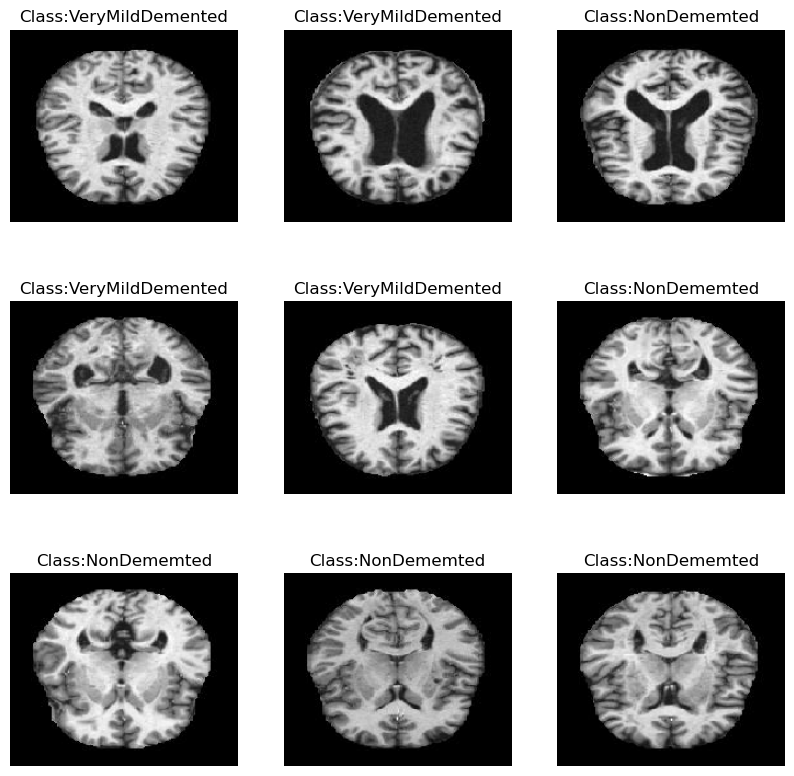

In [7]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASS_LIST))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[i])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_gen)

# Try #1

<a id="3"></a>
# <p>InceptionV3 Model</p>
<a href="#home"></a>

# Model Building and Evaluation Functions
Several functions were built to assist with model building, training, and evaluation

## Function:Plot Training Metrics
This function was used throughout the analysis to plot training metrics. It plots loss by epochs, AUC by epochs, and the four-class confusion matrix with the training AUC metric. AUC was chosen as the performance metric instead of accuracy due to the class imbalance in the training images

In [8]:
def plot_training_metrics(train_hist,model,test_gen,y_actual,y_pred,classes):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    
    # Evaluate the results:
    test_loss, test_metric = model.evaluate(test_gen,verbose = False)
    results       = round(test_metric,2)*100 
    results_title ="\n Model AUC on Test Data:{}%".format(results)
    print(results_title.format(results))
    print(len(results_title) * "-")
    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[results/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()

    
    # calculate Confusion Matrix
    cm = confusion_matrix(y_actual, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title("Confusion Matrix \n AUC:{}%".format(results))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Function: Freeze/Un-Freeze Model Layers
Transfer learning requires us to freeze some of the model layers to reuse pre-trained model weights. This function will freeze all, some or none of the layers in a base model. The trainable_layers parameter is used to freeze 'all' base weights to reuse all pre-trained weights, 'none' to forget all training weights, or 'some' to freeze a subset of weights. To freeze only some of the weights you need to provide the layer name and block numbers

+ trainable_layers: 'all' => retrain all layers
+ trainable_layers: 'none'=> keep all pretrained weights
+ trainable_layers: 'some'=> must provide the layer name,ranges to freeze

In [9]:
def freeze_layers(base,conv_num="conv5",block_num=1,max_block_num=16,trainable_layers='some'):
    """
    Input: A base transferable model,the layer name, the block number, the max number of blocks
           The layer name, block number and max of blocks only works with DenseNet121
    Output:Sets all layers to trainable from conv#_block_num to conv#_max_block_num
    
    """
    if trainable_layers=='none':
        base.trainable = False
        print("No Layers Trainable: Using Base Model Weights")
    if trainable_layers=='all':
        base.trainable =True
        print("All Layers Trainable: Base Model will be fully trained")
    
    if trainable_layers=='some':
        
        print("Some Layers of the Model will be Trainable:")
        print("---------------------------------------------")
        
        # set all layers to not trainable
        base.trainable = False

        # loop through all layers from conv#_block# and set to true
        print('layer','\t\t\t','trainable')
        for block in range(block_num,max_block_num+1):
            for layer in conv_base.layers:
                if block>=block_num:
                    if conv_num +"_block"+str(block) in layer.name:
                        layer.trainable = True
                        print(layer.name,'\t',layer.trainable)

## Function: Build & Compile a Transfer Model
This function takes a base model and training parameters and returns a compiled model.

In [10]:
# function to build the model
def build_transfer_model(conv_base,dropout,dense_node,learn_rate,metric):
    """
    Build and compile a transfer learning model
    Input: a base model, dropout rate, the number of filters in the dense node, 
           the learning rate and performance metrics
    Output: A compiled CNN model
    """
    
    # clear previous run
    backend.clear_session()
    
    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

# Select a Base Model
To select a base model for transfer learning a simple model was trained using DenseNet121, InceptionV3, Xception and ResNet101 with a single dense layer for classification. All pre-trained weights were frozen and the AUC for the training set was calculated. The image dataset is unbalanced with unequal examples of classes. Accuracy would be biased towards the highest frequency class, so AUC was selected as an alternative model performance metric.

## Base Model: Transfer Learning
+ freeze the weights in the base model
+ add a single dense layer for classification
+ add callbacks for early stopping based on validation AUC
+ use AUC as the performance metric
+ train the model with each base models: DenseNet121, VGG19, InceptionV3, Xception,ResNet101
+ select the best base based on AUC

In [11]:
# training parameters
EPOCHS        = 15
# This callback will stop the training when a monitored quantity has stopped improving
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 5,restore_best_weights=True)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc')]

<a id="4"></a>
## <p>InceptionV3</p>
<a href="#home"></a>
+ InceptionV3 pre-trained on ImageNet and remove the top layer
+ 'imagenet'-> weights that were learned from training on the ImageNet dataset.
+ trainable_layers -> 'none'
+ learn_rate=0.001
+ EPOCHS = 15
+ Added layers
+ Optimizer = 'Adam'
+ loss = 'categorical_crossentropy'
+ Accuracy = 64%


87910968/87910968 [==============================] - 24s 0us/step
No Layers Trainable: Using Base Model Weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 5, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 4, 5, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 40960)             0         
                                                                 
 dense (Dense)               (None, 512)               20972032  
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                        

128/128 - 233s - loss: 2.6489 - auc: 0.8009 - val_loss: 0.7710 - val_auc: 0.8943 - 233s/epoch - 2s/step
Epoch 2/15
128/128 - 214s - loss: 0.6377 - auc: 0.9259 - val_loss: 0.6644 - val_auc: 0.9219 - 214s/epoch - 2s/step
Epoch 3/15
128/128 - 209s - loss: 0.4421 - auc: 0.9649 - val_loss: 0.4490 - val_auc: 0.9642 - 209s/epoch - 2s/step
Epoch 4/15
128/128 - 212s - loss: 0.3583 - auc: 0.9762 - val_loss: 0.4363 - val_auc: 0.9655 - 212s/epoch - 2s/step
Epoch 5/15
128/128 - 195s - loss: 0.2725 - auc: 0.9860 - val_loss: 0.3953 - val_auc: 0.9712 - 195s/epoch - 2s/step
Epoch 6/15
128/128 - 120s - loss: 0.2073 - auc: 0.9918 - val_loss: 0.3538 - val_auc: 0.9777 - 120s/epoch - 934ms/step
Epoch 7/15
128/128 - 115s - loss: 0.1606 - auc: 0.9949 - val_loss: 0.4170 - val_auc: 0.9693 - 115s/epoch - 902ms/step
Epoch 8/15
128/128 - 118s - loss: 0.1386 - auc: 0.9963 - val_loss: 0.3788 - val_auc: 0.9748 - 118s/epoch - 922ms/step
Epoch 9/15
128/128 - 117s - loss: 0.1227 - auc: 0.9967 - val_loss: 0.4094 - val_au

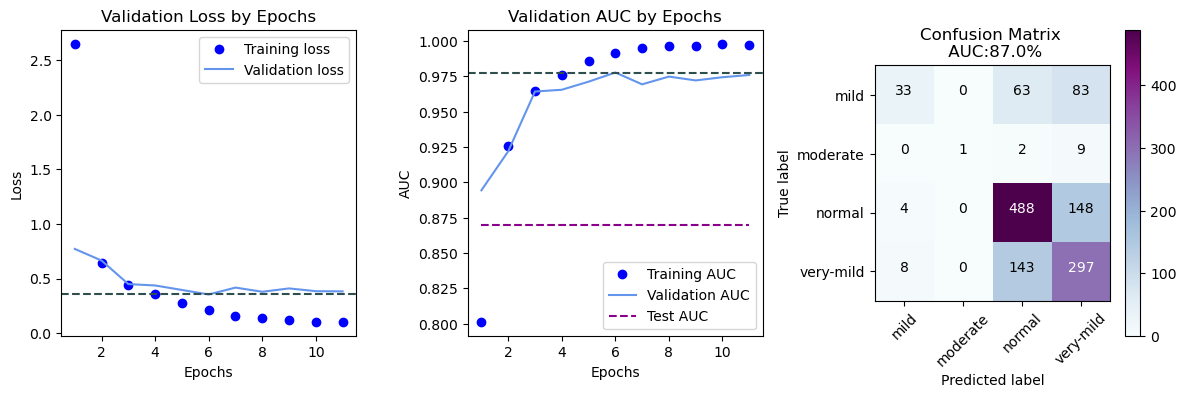

INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


Total Time:35.6


In [17]:
# Train Model: Base Model
# get base
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.4,dense_node =512,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot training metrics
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# Save the Model
model.save(os.path.join(DIR_MODELS,'base_model'))

# display runtime
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

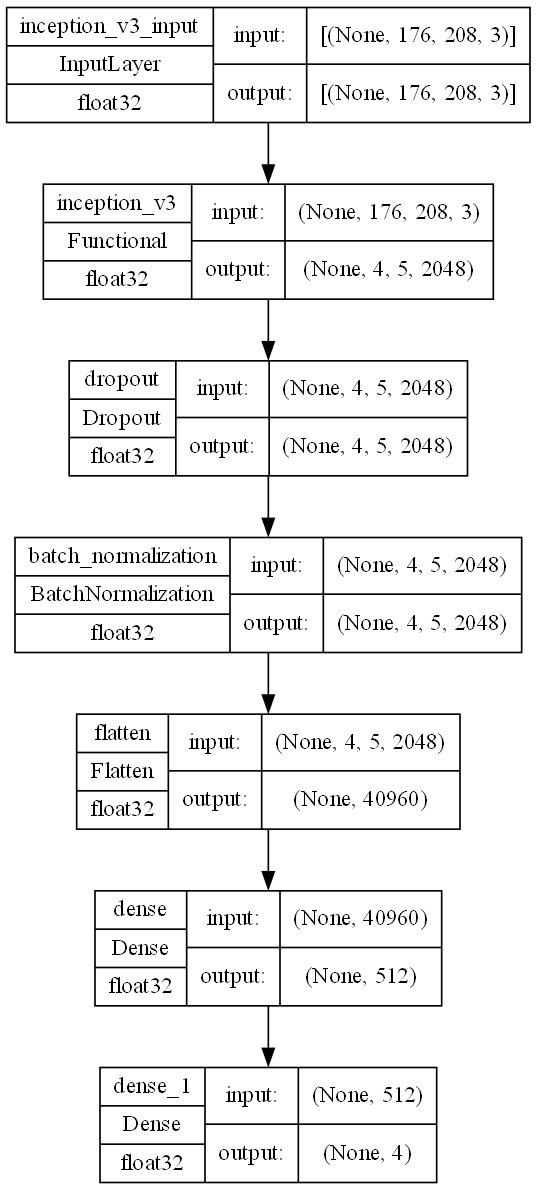

In [20]:
# schematic diagram
tf.keras.utils.plot_model(model, to_file='InceptionV3.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

## Tune Model Hyperparameters

InceptionV3 had the highest AUC on the test dataset and was selected as the base model (only InceptionV3 is shown for brevity). A number of additional steps were taken to improve the test AUC

<a id="5"></a>
## <p>Base Model (Inceptionv3) + Additional Capacity</p>
<a href="#home"></a>
To increase the capacity of the model additional convolution layers were added along with dropout and batch normalization for regularization. The build transfer model function was adjusted to add the additional layers.

In [14]:
# function to build the model
# add an additional conv layer with dropout and batch normalization
def build_transfer_model(conv_base,dropout,conv_nodes,dense_node,learn_rate,metric):
    """
    Build and compile a transfer learning model
    """
    
    # clear previous run
    backend.clear_session()
    
    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
    model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout +0.10))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

## InceptionV3 + Additional Capacity
+ InceptionV3 pre-trained on ImageNet and remove the top layer
+ 'imagenet'-> weights that were learned from training on the ImageNet dataset.
+ trainable_layers -> 'none'
+ learn_rate=0.001
+ EPOCHS = 50
+ Added layers
+ Optimizer = 'Adam'
+ loss = 'categorical_crossentropy'
+ Accuracy = 60%

No Layers Trainable: Using Base Model Weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 5, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 4, 5, 2048)        8192      
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 4, 5, 1024)        18875392  
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 5, 1024)        9438208   
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 1024)        0         
 D)                                                     

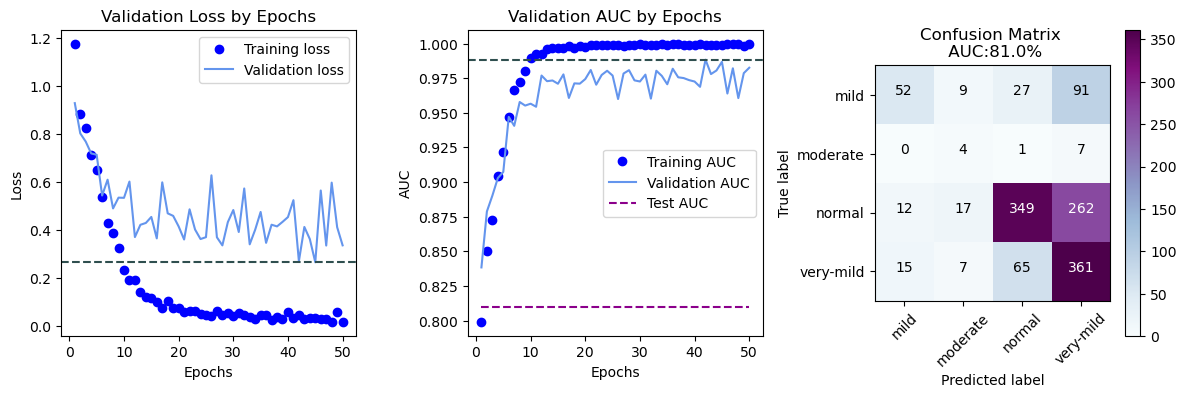

INFO:tensorflow:Assets written to: ./models\model_added_capacity\assets


INFO:tensorflow:Assets written to: ./models\model_added_capacity\assets


Total Time:290.12


In [21]:
# Base Model: Plus Additional Capacity
# training parameters
EPOCHS        = 50
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 10,restore_best_weights=True)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc')]



# Train Model: Base + Additional Capacity
# get base
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# Save Model
model.save(os.path.join(DIR_MODELS,'model_added_capacity'))

# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

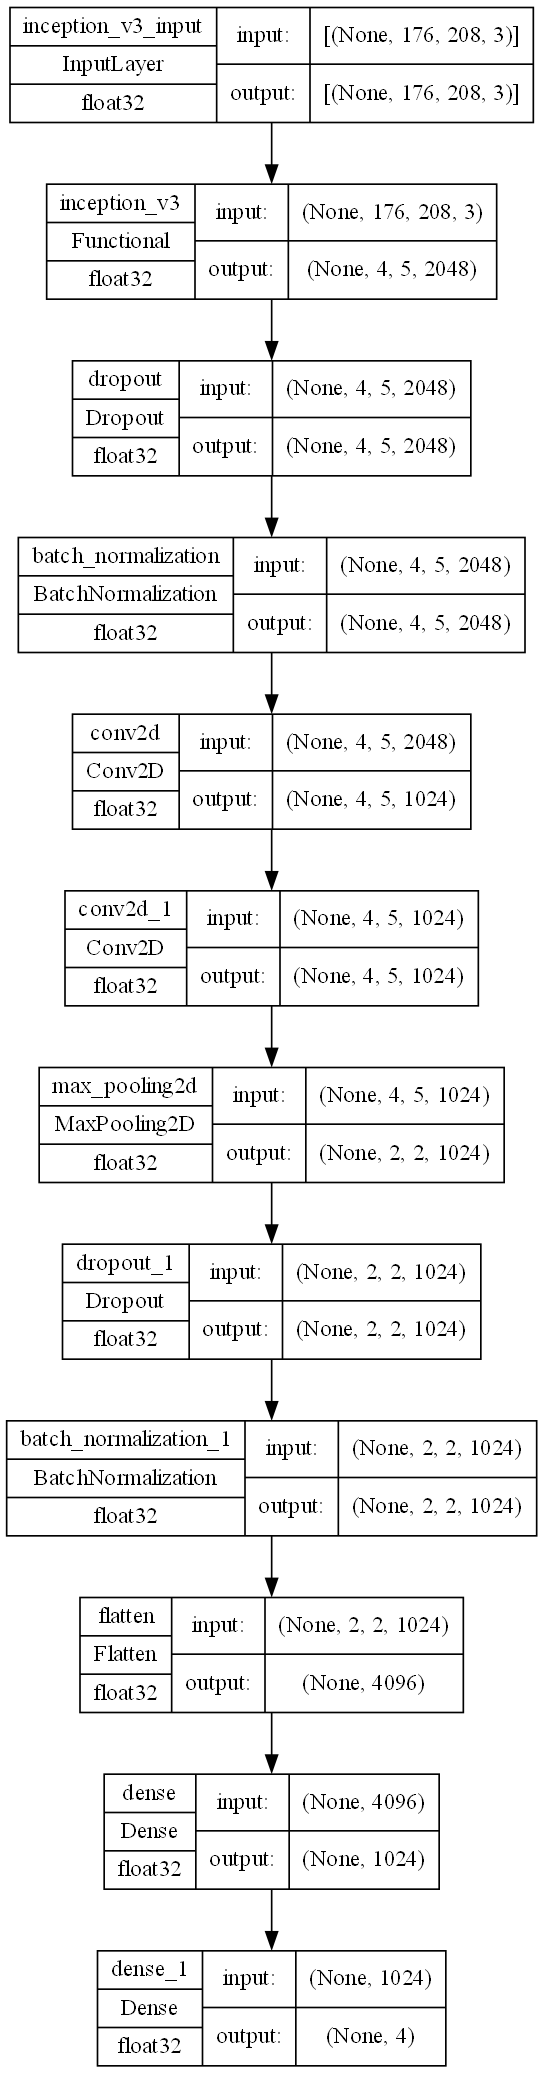

In [22]:
# schematic diagram
tf.keras.utils.plot_model(model, to_file='InceptionV3_1.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

<a id="6"></a>
## <p>Base Model (InceptionV3) + Optimized Parameters + Data Augmentation</p>
<a href="#home"></a>

The model was re-trained with the optimized hyperparameters using data augmentation. The training was slowed down using a reduced schedule for learn-rate, early stopping was removed and the epochs were set to 150 to give the model as much time to train as possible without overfitting

+ InceptionV3 pre-trained on ImageNet and remove the top layer
+ 'imagenet'-> weights that were learned from training on the ImageNet dataset.
+ trainable_layers -> 'none'
+ learn_rate=0.001
+ EPOCHS = 15
+ Added layers
+ Optimizer = 'Adam'
+ loss = 'categorical_crossentropy'
+ Accuracy = 59%

Found 4095 images belonging to 4 classes.


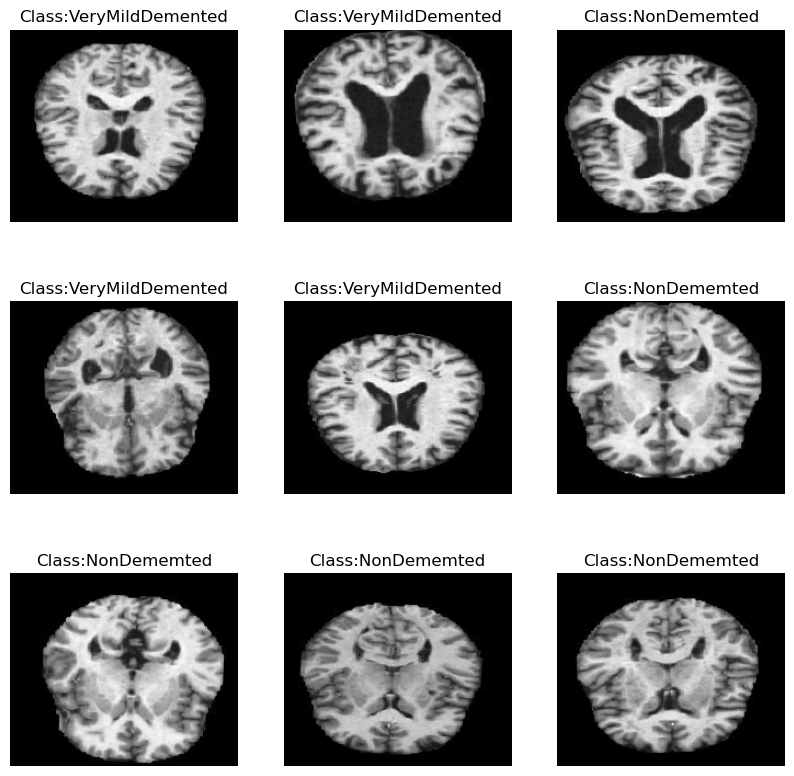

In [12]:
# Data Augmentation on training images
train_images = ImageDataGenerator(rescale            = 1./255,
                                  rotation_range     = 5,
                                  zoom_range         = 0.10,
                                  width_shift_range  =0.05,
                                  height_shift_range =0.05)

# train image generator
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          
    seed        = SEED 
)

show_images(train_gen)

No Layers Trainable: Using Base Model Weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 5, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 4, 5, 2048)        8192      
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 4, 5, 1024)        18875392  
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 5, 1024)        9438208   
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 1024)        0         
 D)                                                     

128/128 - 287s - loss: 1.1502 - auc: 0.7946 - val_loss: 0.8913 - val_auc: 0.8469 - lr: 0.0010 - 287s/epoch - 2s/step
Epoch 2/15
128/128 - 274s - loss: 0.9346 - auc: 0.8324 - val_loss: 0.8981 - val_auc: 0.8550 - lr: 0.0010 - 274s/epoch - 2s/step
Epoch 3/15
128/128 - 271s - loss: 0.8952 - auc: 0.8450 - val_loss: 0.9215 - val_auc: 0.8514 - lr: 0.0010 - 271s/epoch - 2s/step
Epoch 4/15
128/128 - 276s - loss: 0.8745 - auc: 0.8545 - val_loss: 0.9184 - val_auc: 0.8340 - lr: 0.0010 - 276s/epoch - 2s/step
Epoch 5/15
128/128 - 277s - loss: 0.8413 - auc: 0.8645 - val_loss: 0.7771 - val_auc: 0.8850 - lr: 0.0010 - 277s/epoch - 2s/step
Epoch 6/15
128/128 - 276s - loss: 0.8145 - auc: 0.8750 - val_loss: 0.7711 - val_auc: 0.8872 - lr: 0.0010 - 276s/epoch - 2s/step
Epoch 7/15
128/128 - 277s - loss: 0.8006 - auc: 0.8772 - val_loss: 0.7576 - val_auc: 0.8929 - lr: 0.0010 - 277s/epoch - 2s/step
Epoch 8/15
128/128 - 275s - loss: 0.7653 - auc: 0.8874 - val_loss: 0.7286 - val_auc: 0.9013 - lr: 0.0010 - 275s/epo

F:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


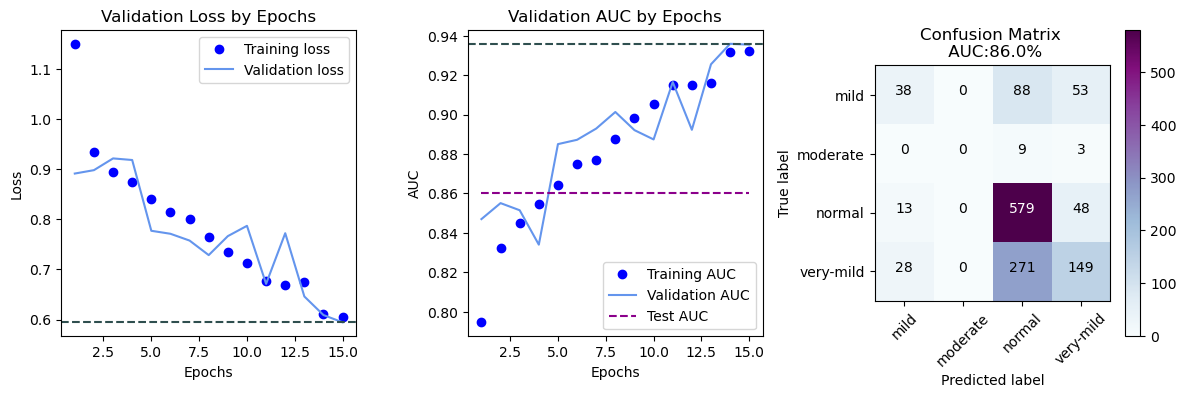

INFO:tensorflow:Assets written to: ./models\model_added_capacity\assets


INFO:tensorflow:Assets written to: ./models\model_added_capacity\assets


Total Time:75.06 mins


In [15]:
# training parameters
EPOCHS        = 15
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 15,restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_auc',factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [reduce_lr]
metrics       = [tf.keras.metrics.AUC(name='auc')]



# Train Model: Base + Optimized Hyperparameters + Data Augmentation
# get base
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        =callbacks 
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# Save Model
model.save(os.path.join(DIR_MODELS,'model_added_capacity'))

# time
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

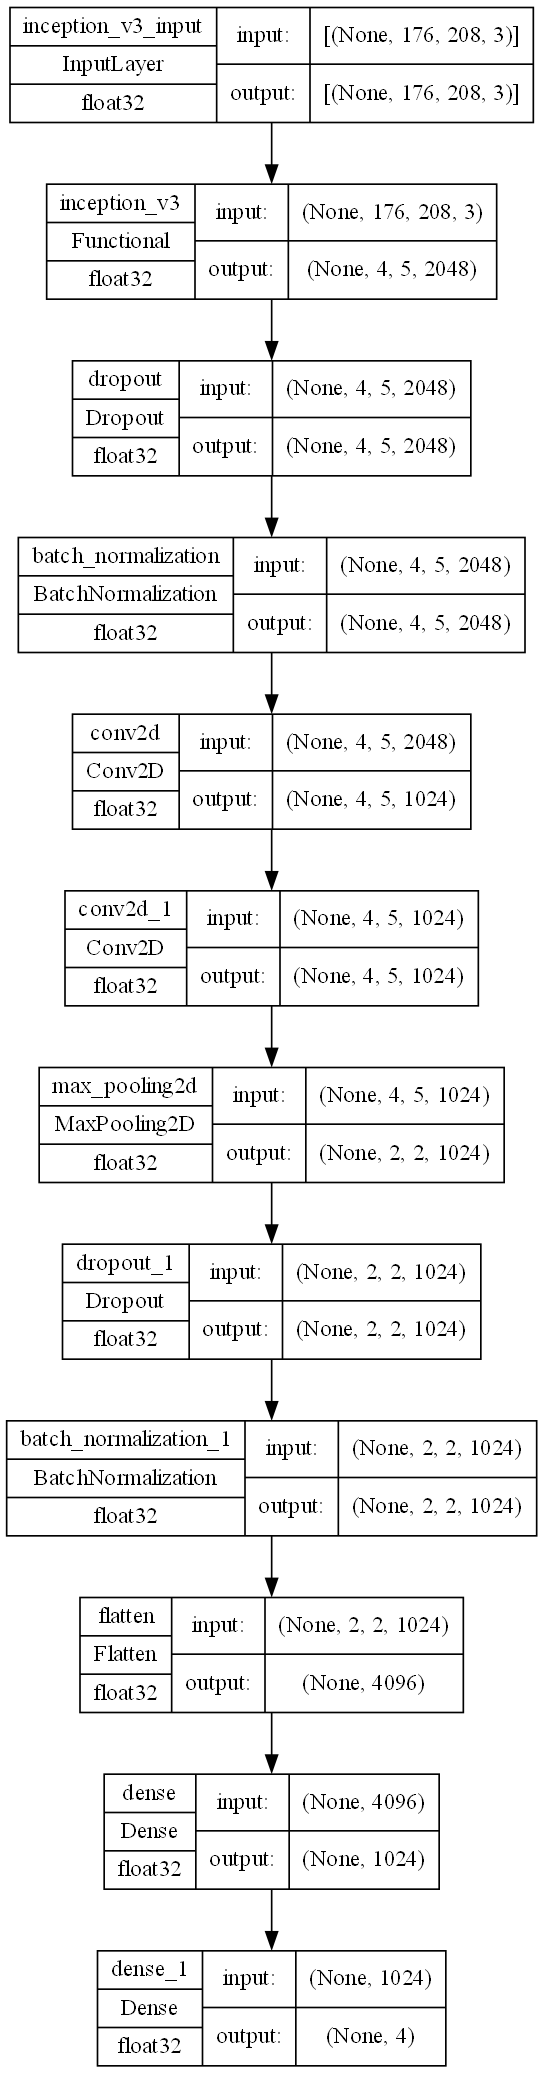

In [16]:
# schematic diagram
tf.keras.utils.plot_model(model, to_file='InceptionV3_2.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

# Try #2

<a id="7"></a>
## <p>Xception</p>
<a href="#home"></a>
+ Xception pre-trained on ImageNet and remove the top layer
+ 'imagenet'-> weights that were learned from training on the ImageNet dataset.
+ trainable_layers -> False
+ learn_rate=0.001
+ EPOCHS = 50
+ pooling = 'max', Dense, Dropout, Dense
+ Optimizer = 'Adam'
+ loss = 'categorical_crossentropy'
+ Accuracy = 65%

In [15]:
# Create Model Structure
# class_count = len(list(train_generator.class_indices.keys())) # to define number of classes in dense layer

base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet", input_shape = (*IMG_SIZE, 3), pooling= 'max',)

model = tf.keras.models.Sequential([
    base_model,
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])

model.compile(optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 21912620 (83.59 MB)
Trainable params: 21858092 (83.38 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [32]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

history = model.fit(train_gen,
    validation_data=val_gen,
    epochs=50, 
    steps_per_epoch = 100,
    callbacks = [early_stopping_callbacks])

Epoch 1/50
100/100 [==============================] - 461s 5s/step - loss: 1.0369 - accuracy: 0.5420 - val_loss: 2.3735 - val_accuracy: 0.4990
Epoch 2/50
100/100 [==============================] - 443s 4s/step - loss: 0.7175 - accuracy: 0.6755 - val_loss: 3.6832 - val_accuracy: 0.5010
Epoch 3/50
100/100 [==============================] - 451s 5s/step - loss: 0.4781 - accuracy: 0.8109 - val_loss: 4.2827 - val_accuracy: 0.5107
Epoch 4/50
100/100 [==============================] - 443s 4s/step - loss: 0.3196 - accuracy: 0.8843 - val_loss: 1.7333 - val_accuracy: 0.6745
Epoch 5/50
100/100 [==============================] - 441s 4s/step - loss: 0.1980 - accuracy: 0.9253 - val_loss: 8.8883 - val_accuracy: 0.4990
Epoch 6/50
100/100 [==============================] - 446s 4s/step - loss: 0.1383 - accuracy: 0.9509 - val_loss: 0.7630 - val_accuracy: 0.8324
Epoch 7/50
100/100 [==============================] - 459s 5s/step - loss: 0.1231 - accuracy: 0.9562 - val_loss: 0.2870 - val_accuracy: 0.9250

In [35]:
loss, accuracy = model.evaluate(test_gen)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

40/40 [==============================] - 45s 1s/step - loss: 1.4323 - accuracy: 0.6529
Loss:  1.4322588443756104
Accuracy:  0.652853786945343


In [40]:
 # get class predictions
y_prob = model.predict(test_gen)
y_pred_Xception = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# print classification report
print(classification_report(y_actual, y_pred_Xception, target_names=CLASS_LIST))

40/40 [==============================] - 45s 1s/step
                  precision    recall  f1-score   support

    MildDememted       0.68      0.43      0.53       179
ModerateDemented       1.00      0.42      0.59        12
     NonDememted       0.86      0.59      0.70       640
VeryMildDemented       0.52      0.84      0.64       448

        accuracy                           0.65      1279
       macro avg       0.77      0.57      0.61      1279
    weighted avg       0.72      0.65      0.65      1279



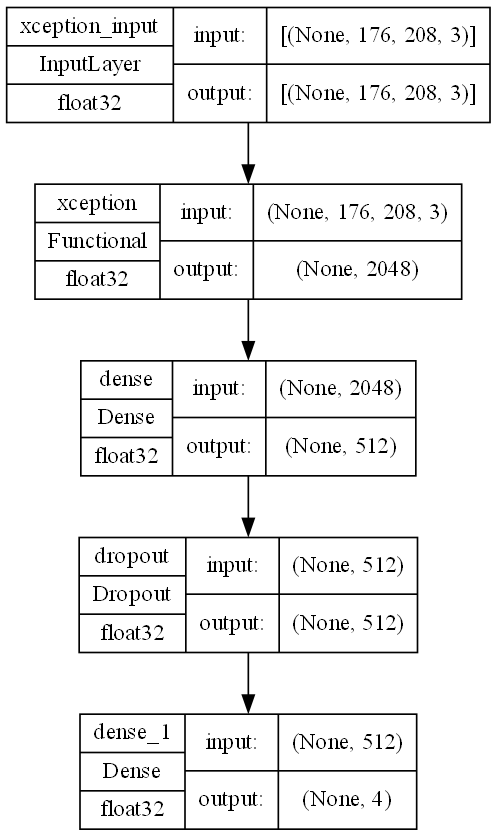

In [16]:
tf.keras.utils.plot_model(model, to_file='Xception.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

# Try #3

<a id="8"></a>
## <p>VGG19</p>
<a href="#home"></a>
+ VGG19 pre-trained on ImageNet and remove the top layer
+ 'imagenet'-> weights that were learned from training on the ImageNet dataset.
+ trainable_layers -> False
+ learn_rate=0.001
+ EPOCHS = 10
+ Flatten and Added Dense layer
+ Optimizer = 'Adam'
+ loss = 'categorical_crossentropy'
+ Accuracy = 67%

In [17]:
vgg = VGG19(input_shape = (*IMG_SIZE, 3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0     

In [15]:
modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

In [23]:
modelvgg.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=callback)

Epoch 1/10
128/128 [==============================] - 687s 5s/step - loss: 0.3555 - auc: 0.9815 - acc: 0.8716 - val_loss: 0.4743 - val_auc: 0.9582 - val_acc: 0.7934
Epoch 2/10
128/128 [==============================] - 596s 5s/step - loss: 0.3190 - auc: 0.9870 - acc: 0.8926 - val_loss: 0.4658 - val_auc: 0.9617 - val_acc: 0.8051
Epoch 3/10
128/128 [==============================] - 606s 5s/step - loss: 0.2885 - auc: 0.9908 - acc: 0.9138 - val_loss: 0.3825 - val_auc: 0.9778 - val_acc: 0.8684
Epoch 4/10
128/128 [==============================] - 598s 5s/step - loss: 0.2715 - auc: 0.9926 - acc: 0.9216 - val_loss: 0.4083 - val_auc: 0.9688 - val_acc: 0.8148
Epoch 5/10
128/128 [==============================] - 553s 4s/step - loss: 0.2704 - auc: 0.9912 - acc: 0.9165 - val_loss: 0.3247 - val_auc: 0.9843 - val_acc: 0.8879
Epoch 6/10
128/128 [==============================] - 547s 4s/step - loss: 0.2459 - auc: 0.9933 - acc: 0.9241 - val_loss: 0.3483 - val_auc: 0.9818 - val_acc: 0.8684
Epoch 7/10

In [24]:
loss, auc,accuracy = modelvgg.evaluate(test_gen)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

40/40 [==============================] - 133s 3s/step - loss: 0.8625 - auc: 0.8931 - acc: 0.6693
Loss:  0.8624967336654663
AUC:  0.8930867910385132
Accuracy:  0.6692728400230408


In [26]:
 # get class predictions
y_prob = modelvgg.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# print classification report
print(classification_report(y_actual, y_pred, target_names=CLASS_LIST))

40/40 [==============================] - 139s 4s/step
                  precision    recall  f1-score   support

    MildDememted       0.67      0.32      0.44       179
ModerateDemented       1.00      0.33      0.50        12
     NonDememted       0.79      0.67      0.72       640
VeryMildDemented       0.56      0.82      0.67       448

        accuracy                           0.67      1279
       macro avg       0.76      0.54      0.58      1279
    weighted avg       0.70      0.67      0.66      1279



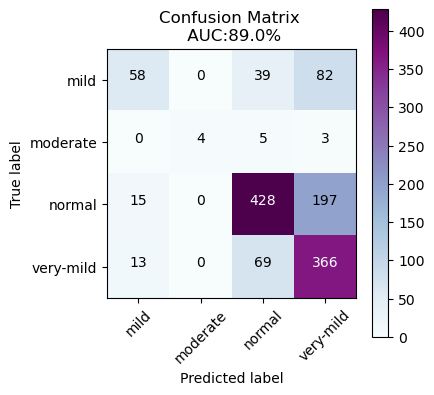

In [38]:
# calculate Confusion Matrix
# create plots
plt.subplots(figsize=(12,4))
classes = ['mild','moderate','normal','very-mild']
cm = confusion_matrix(y_actual, y_pred)

# create confusion matrix plot
plt.subplot(1,3,3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
plt.title("Confusion Matrix \n AUC:{}%".format(round(auc,2)*100 ))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(c, r, format(cm[r, c], 'd'),
             horizontalalignment="center",
             color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

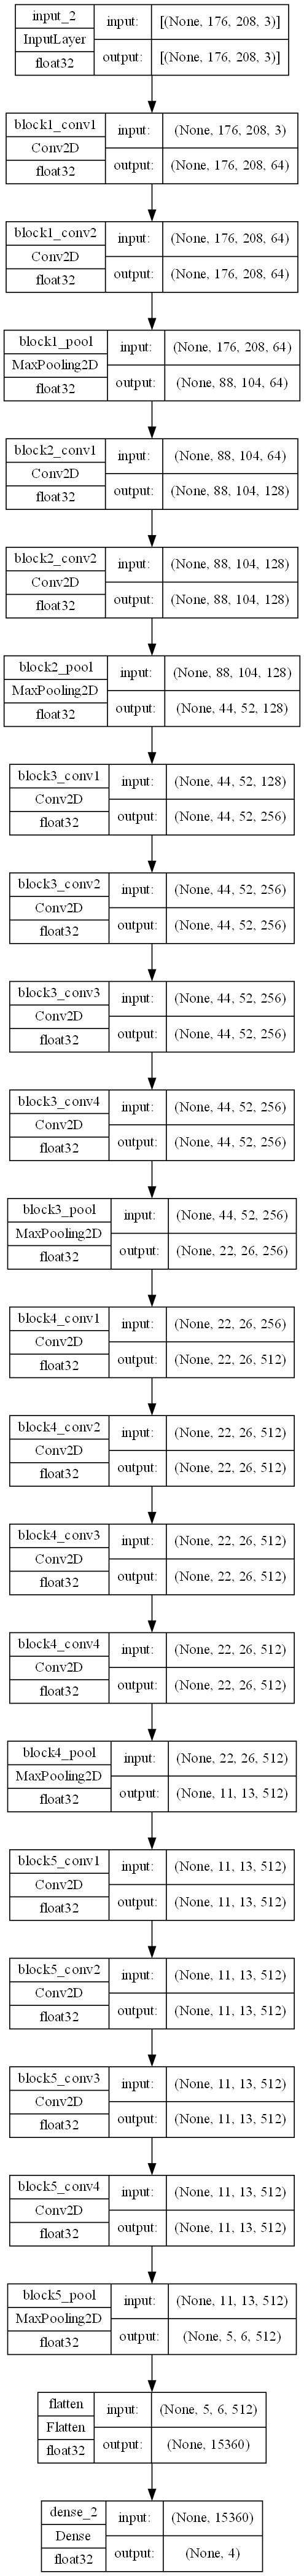

In [18]:
# schematic diagram
tf.keras.utils.plot_model(modelvgg, to_file='VGG19.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

<a id="9"></a>
# <p>View Images and Labels For VGG19 </p>
<a href="#home"></a>
We can view examples of actual and predicted labels with the show_images function by providing the predicted labels

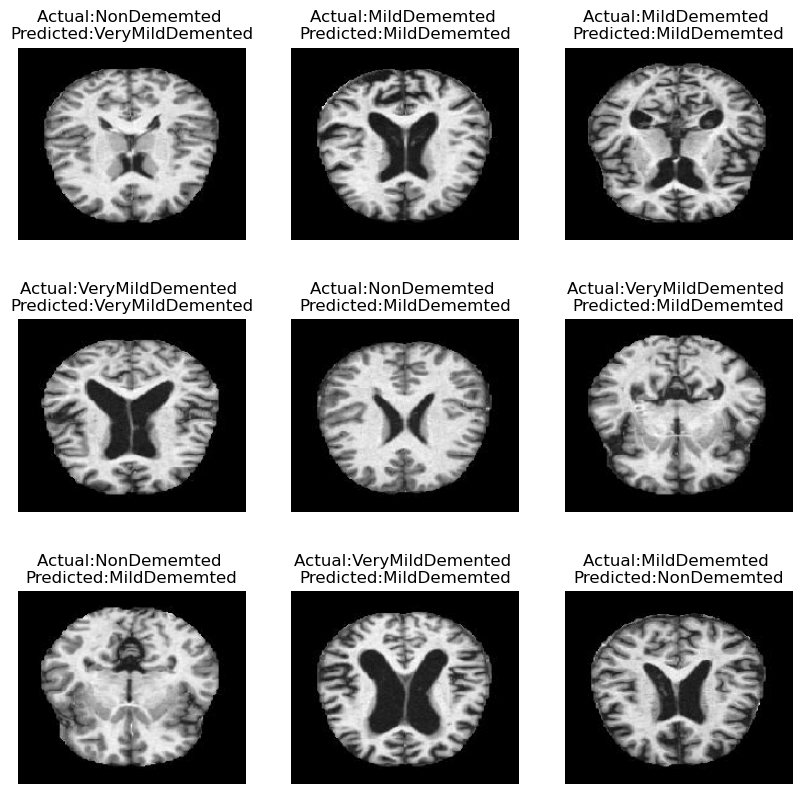

In [39]:
# show_images and labels
show_images(train_gen,y_pred)